In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import sys
import helper_functions
sys.path.append("../../")
from src.mps import mps
from src.mps import mps_runge_kutta
from src.mps import tfi_model
from src.mps import multiplication
from src.mps import addition

In [3]:
J = 1.
g = 1.5
chi_max = 10
eps = 1.e-15
dts = [0.1, 0.01, 0.001]
t_stop = 10*J
L = 14
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])

In [4]:
psi_0 = mps.MPS.initialize_spinup(L)
psi_0_state = np.zeros(2**L)
psi_0_state[0] = 1.

In [5]:
model = tfi_model.TFIModel(L, J, g)

In [6]:
# prepare mpo
update_mpo = model.H_mpo
factor = np.power(-1.j, 1/L)
print(factor)
for i in range(len(update_mpo)):
    update_mpo[i] = factor * update_mpo[i].copy()

(0.9937122098932426-0.11196447610330786j)


In [7]:
ms = []
entropies = []

ms = [[] for i in range(len(dts))]
entropies = [[] for i in range(len(dts))]

for i, dt in enumerate(dts):
    psi = mps.MPS.initialize_spinup(L)
    N = (int)(np.ceil(t_stop/dt))
    print("Computing dt =", dt)
    for _ in tqdm(range(N)):
        ms[i].append(np.sum(psi.site_expectation_value(sigma_z)))
        psi = mps_runge_kutta.integrate_MPS_RK4(psi, dt, update_mpo, chi_max, eps)
        entropies[i].append(psi.entanglement_entropy()[L//2])

Computing dt = 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

Computing dt = 0.01


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing dt = 0.001


  0%|          | 0/10000 [00:00<?, ?it/s]

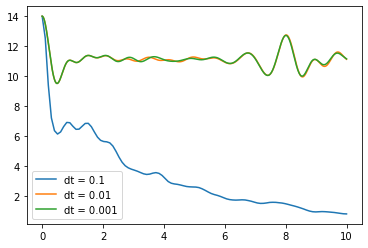

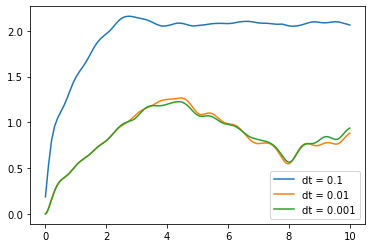

In [8]:
for i, dt in enumerate(dts):
    N = (int)(np.ceil(t_stop/dt))
    plt.plot(np.linspace(0, t_stop, N), ms[i], label="dt = "+str(dt))
plt.legend()
plt.show()

for i, dt in enumerate(dts):
    N = (int)(np.ceil(t_stop/dt))
    plt.plot(np.linspace(0, t_stop, N), entropies[i], label="dt = "+str(dt))
plt.legend()
plt.show()

# Runge-Kutta using normal state vectors

In [12]:
H = helper_functions.generate_TFI_Hamiltonian(L, J, g)

In [13]:
def measure_site_op(psi, L, op):
    result = 0
    for i in range(L):
        operator = helper_functions.singlesite_to_full(op, i, L)
        result = result + np.real_if_close((np.conj(psi.T)@operator@psi)/(np.conj(psi.T)@psi))
    return result

In [14]:
ms = []

psi = psi_0_state.copy()
dt = 0.1
N = (int)(np.ceil(t_stop/dt))

for i in tqdm(range(N)):
    ms.append(measure_site_op(psi, L, sigma_z))
    k1 = -1.j*H@psi
    k2 = -1.j*H@(psi+dt/2*k1)
    k3 = -1.j*H@(psi+dt/2*k2)
    k4 = -1.j*H@(psi+dt*k3)
    psi = psi + 1/6*dt*(k1+2*k2+2*k3+k4)
    psi /= np.linalg.norm(psi)

  0%|          | 0/100 [00:00<?, ?it/s]

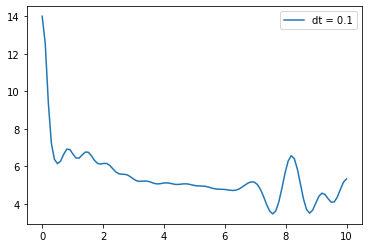

In [15]:
N = (int)(np.ceil(t_stop/dt))
plt.plot(np.linspace(0, t_stop, N), ms, label="dt = "+str(dt))
plt.legend()
plt.show()

Already with dt = 0.01 this reproduces pretty well the TEBD/TDVP result!

# Comparing the two

In [38]:
chi_max = 1000
eps = 0

In [39]:
J = 1.
g = 1.5
model = tfi_model.TFIModel(L, J, g)
H = helper_functions.generate_TFI_Hamiltonian(L, J, g)

In [40]:
dt = 0.1

In [41]:
psi_all_up = np.zeros(2**L)
psi_all_up[0] = 1.

In [42]:
# prepare mpo
update_mpo = [None] * L
factor = np.power(-1.j, 1/L)
for i in range(len(model.H_mpo)):
    update_mpo[i] = factor * model.H_mpo[i].copy()

In [43]:
psi_mps = mps.MPS.initialize_from_state_vector(psi_all_up, L)

### k1

In [44]:
k1 = -1.j*H@psi_all_up
k1_mps = multiplication.multiply(psi_mps, update_mpo, chi_max, eps, inplace=False, normalize=False)
k1_compare = k1_mps.to_state_vector()

In [45]:
print(np.max(np.abs(k1-k1_compare)))

2.4868995773233785e-14


### k2

In [52]:
temp = psi_all_up + dt/2*k1
temp_mps = addition.add(psi_mps, k1_mps, chi_max, eps, dt/2)
temp_compare = temp_mps.to_state_vector()

In [53]:
print(np.max(np.abs(temp-temp_compare)))

6.133982734757958e-15


In [54]:
k2 = -1.j*H@temp
k2_mps = multiplication.multiply(temp_mps, update_mpo, chi_max, eps, inplace=False)
k2_compare = k2_mps.to_state_vector()

In [55]:
print(np.max(np.abs(k2-k2_compare)))

3.7707260204788525e-13


### k3

In [57]:
temp = psi_all_up + dt/2*k2
temp_mps = addition.add(psi_mps, k2_mps, chi_max, eps, dt/2)
temp_compare = temp_mps.to_state_vector()

In [58]:
print(np.max(np.abs(temp-temp_compare)))

1.9698056925209707e-14


In [60]:
k3 = -1.j*H@temp
k3_mps = multiplication.multiply(temp_mps, update_mpo, chi_max, eps, inplace=False)
k3_compare = k3_mps.to_state_vector()

In [61]:
print(np.max(np.abs(k3-k3_compare)))

7.014999156114662e-13


### k4

In [62]:
temp = psi_all_up + dt*k3
temp_mps = addition.add(psi_mps, k3_mps, chi_max, eps, dt)
temp_compare = temp_mps.to_state_vector()

In [63]:
print(np.max(np.abs(temp-temp_compare)))

6.980191764437584e-14


In [64]:
k4 = -1.j*H@temp
k4_mps = multiplication.multiply(temp_mps, update_mpo, chi_max, eps, inplace=False)
k4_compare = k4_mps.to_state_vector()

In [65]:
print(np.max(np.abs(k3-k3_compare)))

7.014999156114662e-13


### final step

In [68]:
psi_final = psi_all_up + dt/6*(k1+2*k2+2*k3+k4)
#psi_final /= np.linalg.norm(psi_final)
psi_final_mps = addition.add(psi_mps, k1_mps, chi_max, eps, dt/6)
psi_final_mps = addition.add(psi_final_mps, k2_mps, chi_max, eps, dt*2/6)
psi_final_mps = addition.add(psi_final_mps, k3_mps, chi_max, eps, dt*2/6)
psi_final_mps = addition.add(psi_final_mps, k4_mps, chi_max, eps, dt/6)
psi_final_compare = psi_final_mps.to_state_vector()

In [69]:
print(np.max(np.abs(psi_final-psi_final_compare)))

3.092783876415224e-14


In [70]:
print(measure_site_op(psi_all_up, L, sigma_z))
print(np.sum(psi_mps.site_expectation_value(sigma_z)))

14.0
14.0


In [71]:
print(measure_site_op(psi_final, L, sigma_z))
print(np.sum(psi_final_mps.site_expectation_value(sigma_z)))

12.549772659465372
12.549772659465562


## second RK step

### k1

In [72]:
k1 = -1.j*H@psi_final
k1_mps = multiplication.multiply(psi_final_mps, update_mpo, chi_max, eps, inplace=False)
k1_compare = k1_mps.to_state_vector()

In [73]:
print(np.max(np.abs(k1-k1_compare)))

6.227190174331507e-13


### k2

In [74]:
temp = psi_final + dt/2*k1
temp_mps = addition.add(psi_final_mps, k1_mps, chi_max, eps, dt/2)
temp_compare = temp_mps.to_state_vector()

In [75]:
print(np.max(np.abs(temp-temp_compare)))

5.008818070875817e-14


In [76]:
k2 = -1.j*H@temp
k2_mps = multiplication.multiply(temp_mps, update_mpo, chi_max, eps, inplace=False)
k2_compare = k2_mps.to_state_vector()

In [77]:
print(np.max(np.abs(k2-k2_compare)))

9.533804197651422e-13


### k3

In [78]:
temp = psi_final + dt/2*k2
temp_mps = addition.add(psi_final_mps, k2_mps, chi_max, eps, dt/2)
temp_compare = temp_mps.to_state_vector()

In [79]:
print(np.max(np.abs(temp-temp_compare)))

3.544213393672586e-14


In [80]:
k3 = -1.j*H@temp
k3_mps = multiplication.multiply(temp_mps, update_mpo, chi_max, eps, inplace=False)
k3_compare = k3_mps.to_state_vector()

In [81]:
print(np.max(np.abs(k3-k3_compare)))

8.580465505103848e-13


### k4

In [82]:
temp = psi_final + dt*k3
temp_mps = addition.add(psi_final_mps, k3_mps, chi_max, eps, dt)
temp_compare = temp_mps.to_state_vector()

In [83]:
print(np.max(np.abs(temp-temp_compare)))

7.455302739264765e-14


In [84]:
k4 = -1.j*H@temp
k4_mps = multiplication.multiply(temp_mps, update_mpo, chi_max, eps, inplace=False)
k4_compare = k4_mps.to_state_vector()

In [85]:
print(np.max(np.abs(k3-k3_compare)))

8.580465505103848e-13


### final step

In [88]:
psi_final_2 = psi_final + dt/6*(k1+2*k2+2*k3+k4)
psi_final_mps_2 = addition.add(psi_final_mps, k1_mps, chi_max, eps, dt/6)
psi_final_mps_2 = addition.add(psi_final_mps_2, k2_mps, chi_max, eps, dt*2/6)
psi_final_mps_2 = addition.add(psi_final_mps_2, k3_mps, chi_max, eps, dt*2/6)
psi_final_mps_2 = addition.add(psi_final_mps_2, k4_mps, chi_max, eps, dt/6)
psi_final_2_compare = psi_final_mps_2.to_state_vector()

In [89]:
print(np.max(np.abs(psi_final_2-psi_final_2_compare)))

3.290402417872168e-14


In [90]:
print(measure_site_op(psi_final_2, L, sigma_z))
print(np.sum(psi_final_mps_2.site_expectation_value(sigma_z)))

9.400762963376666
9.40076296337674


# Full Runge-Kutta run using MPS

In [91]:
chi_max = 10
eps = 1.e-15

L = 14
J = 1.
g = 1.5

dt = 0.1

# prepare initial state
psi_all_up = np.zeros(2**L)
psi_all_up[0] = 1.

# prepare mpo
model = tfi_model.TFIModel(L, J, g)
update_mpo = [None] * L
factor = np.power(-1.j, 1/L)
for i in range(len(model.H_mpo)):
    update_mpo[i] = factor * model.H_mpo[i].copy()

In [93]:
ms_mps = []
ms = []
entropies = []

psi_mps = mps.MPS.initialize_from_state_vector(psi_all_up.copy(), L, chi_max)

N = (int)(np.ceil(t_stop/dt))

for i in tqdm(range(N)):
    m_mps = np.sum(psi_mps.site_expectation_value(sigma_z))
    m = measure_site_op(psi, L, sigma_z)
    print(m_mps, m)
    ms_mps.append(m_mps)
    ms.append(m)
    
    # RK4 (MPS)
    psi_mps = mps_runge_kutta.integrate_MPS_RK4(psi_mps, dt, update_mpo, chi_max, eps)
    
    # RK4 (state vector)
    k1 = -1.j*H@psi
    k2 = -1.j*H@(psi + dt/2*k1)
    k3 = -1.j*H@(psi + dt/2*k2)
    k4 = -1.j*H@(psi + dt*k3)
    psi = psi + dt/6*(k1+2*k2+2*k3+k4)

  0%|          | 0/100 [00:00<?, ?it/s]

14.0 14.0
12.549772659465477 12.549772659465372
9.40076335731417 9.400762963376666
7.212420103155944 7.212416873325335
6.361018520995755 6.360996051395682
6.136080625872114 6.136001332980636
6.277567853392496 6.277445273666827
6.637110768954596 6.6369832327543286
6.914048351127039 6.911697985451322
6.898146194412127 6.890541487520257
6.666513073448722 6.650700408986139
6.471004323126147 6.441073986601885
6.4895621815845175 6.434527349377303
6.691627439029334 6.597789175081356
6.898657449392177 6.754510616271914
6.935370204702835 6.748728377233082
6.753146325052179 6.564429160951846
6.44814123013099 6.3182312465595505
6.1761038980248175 6.150833336465262
6.041612823804433 6.115629227365471
6.043237727364484 6.151216799163372
6.096776105535028 6.147637954006627
6.099795685510349 6.041468300642377
5.988866764329634 5.860628897668048
5.772804095830253 5.6899653233577405
5.5259356643336375 5.595619043515242
5.333012809804352 5.574516539108664
5.231911247986186 5.5667838359323225
5.201044312

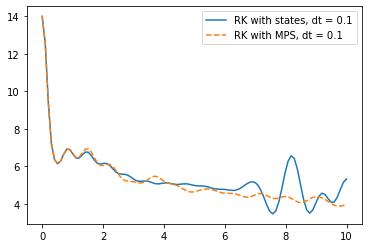

In [94]:
N = (int)(np.ceil(t_stop/dt))

plt.plot(np.linspace(0, t_stop, N), ms, label="RK with states, dt = "+str(dt))
plt.plot(np.linspace(0, t_stop, N), ms_mps, "--", label="RK with MPS, dt = "+str(dt))
plt.legend()
plt.show()

#plt.plot(np.linspace(0, t_stop, N), entropies, label="dt = "+str(dt))
#plt.legend()
#plt.show()

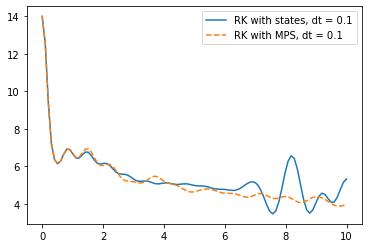

In [209]:
N = (int)(np.ceil(t_stop/dt))

plt.plot(np.linspace(0, t_stop, N), ms, label="RK with states, dt = "+str(dt))
plt.plot(np.linspace(0, t_stop, N), ms_mps, "--", label="RK with MPS, dt = "+str(dt))
plt.legend()
plt.show()

#plt.plot(np.linspace(0, t_stop, N), entropies, label="dt = "+str(dt))
#plt.legend()
#plt.show()